In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoProcessor, AutoModelForVision2Seq, AutoConfig
from datasets import load_dataset
from PIL import Image
import random
from tqdm import tqdm
import numpy as np
import gc
import math
import time
import os
import pandas as pd
import shutil

In [ ]:
# quantized_model_dir = '/kaggle/working/phi3_vision_8bit_quantizers_wf_inspired.pt'
# if os.path.exists(quantized_model_dir):
#     shutil.rmtree(quantized_model_dir)
#     print(f"Removed directory: {quantized_model_dir}")

In [ ]:
base_path = '/kaggle/input/flickr30k'
image_folder_name = 'flickr30k_images'
captions_file_name = 'captions.txt'
calibration_output_dir = '/kaggle/working/flickr30k_calibration'

image_folder = os.path.join(base_path, image_folder_name)
captions_file = os.path.join(base_path, captions_file_name)

df_captions = pd.read_csv(
    captions_file,
    delimiter=',',
    header=None,
    names=['image_name', 'caption_index', 'caption']
)

df_captions['caption'] = df_captions['caption'].astype(str).str.strip()
captions_dict = df_captions.groupby('image_name')['caption'].apply(list).to_dict()
image_paths = {}
for img_name in captions_dict.keys():
    full_path = os.path.join(image_folder, img_name)
    if os.path.exists(full_path):
        image_paths[img_name] = full_path

available_image_names = list(image_paths.keys())
sample_size = min(500, len(available_image_names))
sample_image_names = random.sample(available_image_names, sample_size)

os.makedirs(calibration_output_dir, exist_ok=True)
for img_name in sample_image_names:
    src_path = image_paths[img_name]
    dst_path = os.path.join(calibration_output_dir, img_name)
    shutil.copy(src_path, dst_path)

In [ ]:
%%writefile setup.py
from setuptools import setup, Extension
from torch.utils import cpp_extension

setup(
    name='quant_cuda',
    ext_modules=[cpp_extension.CUDAExtension(
        'quant_cuda', 
        ['quant_cuda.cpp', 'quant_cuda_kernel.cu'] 
    )],
    cmdclass={'build_ext': cpp_extension.BuildExtension} 
)

In [ ]:
%%writefile quant_cuda.cpp
#include <torch/all.h>
#include <torch/python.h>
#include <c10/cuda/CUDAGuard.h>

void vecquant3matmul_cuda(
  torch::Tensor vec, torch::Tensor mat, torch::Tensor mul,
  torch::Tensor scales, torch::Tensor zeros
);

void vecquant3matmul_faster_cuda(
  torch::Tensor vec, torch::Tensor mat, torch::Tensor mul,
  torch::Tensor scales, torch::Tensor zeros
); 

void vecquant3matmul(
  torch::Tensor vec, torch::Tensor mat, torch::Tensor mul,
  torch::Tensor scales, torch::Tensor zeros
) {
  const at::cuda::OptionalCUDAGuard device_guard(device_of(vec));
  vecquant3matmul_cuda(vec, mat, mul, scales, zeros);
}

void vecquant3matmul_faster(
  torch::Tensor vec, torch::Tensor mat, torch::Tensor mul,
  torch::Tensor scales, torch::Tensor zeros
) {
  const at::cuda::OptionalCUDAGuard device_guard(device_of(vec));
  vecquant3matmul_faster_cuda(vec, mat, mul, scales, zeros);
}

PYBIND11_MODULE(TORCH_EXTENSION_NAME, m) {
  m.def("vecquant3matmul", &vecquant3matmul, "Vector 3-bit Quantized Matrix Multiplication (CUDA)");
  m.def("vecquant3matmul_faster", &vecquant3matmul_faster, "Vector 3-bit Quantized Matrix Multiplication (CUDA), faster version");
}


In [ ]:
%%writefile quant_cuda_kernel.cu
#include <torch/all.h>
#include <torch/python.h>
#include <cuda.h>
#include <cuda_runtime.h>
#include <cuda_fp16.h>

template <typename scalar_t>
__global__ void VecQuant3MatMulKernel(
    const  scalar_t* __restrict__ vec,
    const       int* __restrict__ mat,
           scalar_t* __restrict__ mul,
    const  scalar_t* __restrict__ scales,
    const  scalar_t* __restrict__ zeros,
    int height,
    int width
);

__global__ void VecQuant3MatMulKernelFaster(
    const  half2* __restrict__ vec,
    const    int* __restrict__ mat,
           float* __restrict__ mul,
    const  float* __restrict__ scales,
    const  float* __restrict__ zeros,
    int height,
    int width
);

const int BLOCKWIDTH  = 256;
const int BLOCKHEIGHT =  24;

void vecquant3matmul_cuda(
  torch::Tensor vec,
  torch::Tensor mat,
  torch::Tensor mul,
  torch::Tensor scales,
  torch::Tensor zeros
) {
  int height = mat.size(0);
  int width = mat.size(1);

  dim3 blocks(
    (height + BLOCKHEIGHT - 1) / BLOCKHEIGHT,
    (width + BLOCKWIDTH - 1) / BLOCKWIDTH
  );
  dim3 threads(BLOCKWIDTH);

  AT_DISPATCH_FLOATING_TYPES(
    vec.type(), "vecquant3matmul_cuda", ([&] {
      VecQuant3MatMulKernel<<<blocks, threads>>>(
        vec.data<scalar_t>(), mat.data<int>(), mul.data<scalar_t>(),
        scales.data<scalar_t>(), zeros.data<scalar_t>(),
        height, width
      );
    })
  );
}

void vecquant3matmul_faster_cuda(
  torch::Tensor vec,
  torch::Tensor mat,
  torch::Tensor mul,
  torch::Tensor scales,
  torch::Tensor zeros
) {
  int height = mat.size(0);
  int width = mat.size(1);

  dim3 blocks(
    (height + BLOCKHEIGHT - 1) / BLOCKHEIGHT,
    (width + BLOCKWIDTH - 1) / BLOCKWIDTH
  );
  dim3 threads(BLOCKWIDTH);

  VecQuant3MatMulKernelFaster<<<blocks, threads>>>(
    (half2*) vec.data_ptr(),
    mat.data_ptr<int>(),
    mul.data_ptr<float>(),
    scales.data_ptr<float>(),
    zeros.data_ptr<float>(),
    height, width
  );
}

__device__ inline unsigned int as_unsigned(int i) {
  return *reinterpret_cast<unsigned int*>(&i);
}

template <typename scalar_t>
__global__ void VecQuant3MatMulKernel(
    const  scalar_t* __restrict__ vec,
    const       int* __restrict__ mat,
           scalar_t* __restrict__ mul,
    const  scalar_t* __restrict__ scales,
    const  scalar_t* __restrict__ zeros,
    int height,
    int width
) {
  int row = BLOCKHEIGHT * blockIdx.x;
  int col =  BLOCKWIDTH * blockIdx.y + threadIdx.x;

  __shared__ scalar_t blockvec[BLOCKWIDTH];
  blockvec[threadIdx.x] = vec[(row / BLOCKHEIGHT) * BLOCKWIDTH + threadIdx.x];
  __syncthreads();

  scalar_t scale = scales[col];
  scalar_t zero = zeros[col];

  scalar_t res = 0;
  int i = width * row + col;
  int k = 0;

  unsigned int tmp1;
  unsigned int tmp2;
  unsigned int tmp;

  while (k < BLOCKWIDTH) {
    tmp1 = as_unsigned(mat[i]);
    res += (scale * scalar_t((tmp1 >>  0) & 0x7) - zero) * blockvec[k + 0];
    res += (scale * scalar_t((tmp1 >>  3) & 0x7) - zero) * blockvec[k + 1];
    res += (scale * scalar_t((tmp1 >>  6) & 0x7) - zero) * blockvec[k + 2];
    res += (scale * scalar_t((tmp1 >>  9) & 0x7) - zero) * blockvec[k + 3];
    res += (scale * scalar_t((tmp1 >> 12) & 0x7) - zero) * blockvec[k + 4];
    res += (scale * scalar_t((tmp1 >> 15) & 0x7) - zero) * blockvec[k + 5];
    res += (scale * scalar_t((tmp1 >> 18) & 0x7) - zero) * blockvec[k + 6];
    res += (scale * scalar_t((tmp1 >> 21) & 0x7) - zero) * blockvec[k + 7];
    res += (scale * scalar_t((tmp1 >> 24) & 0x7) - zero) * blockvec[k + 8];
    res += (scale * scalar_t((tmp1 >> 27) & 0x7) - zero) * blockvec[k + 9];
    i += width;
    tmp2 = as_unsigned(mat[i]);
    tmp = (tmp1 >> 30) | ((tmp2 << 2) & 0x4);
    tmp2 >>= 1;
    res += (scale * scalar_t(tmp) - zero) * blockvec[k + 10];
    k += 11;
    res += (scale * scalar_t((tmp2 >>  0) & 0x7) - zero) * blockvec[k + 0];
    res += (scale * scalar_t((tmp2 >>  3) & 0x7) - zero) * blockvec[k + 1];
    res += (scale * scalar_t((tmp2 >>  6) & 0x7) - zero) * blockvec[k + 2];
    res += (scale * scalar_t((tmp2 >>  9) & 0x7) - zero) * blockvec[k + 3];
    res += (scale * scalar_t((tmp2 >> 12) & 0x7) - zero) * blockvec[k + 4];
    res += (scale * scalar_t((tmp2 >> 15) & 0x7) - zero) * blockvec[k + 5];
    res += (scale * scalar_t((tmp2 >> 18) & 0x7) - zero) * blockvec[k + 6];
    res += (scale * scalar_t((tmp2 >> 21) & 0x7) - zero) * blockvec[k + 7];
    res += (scale * scalar_t((tmp2 >> 24) & 0x7) - zero) * blockvec[k + 8];
    res += (scale * scalar_t((tmp2 >> 27) & 0x7) - zero) * blockvec[k + 9];
    i += width;
    tmp1 = as_unsigned(mat[i]);
    tmp = (tmp2 >> 30) | ((tmp1 << 1) & 0x6);
    tmp1 >>= 2;
    res += (scale * scalar_t(tmp) - zero) * blockvec[k + 10];
    k += 11;
    res += (scale * scalar_t((tmp1 >>  0) & 0x7) - zero) * blockvec[k + 0];
    res += (scale * scalar_t((tmp1 >>  3) & 0x7) - zero) * blockvec[k + 1];
    res += (scale * scalar_t((tmp1 >>  6) & 0x7) - zero) * blockvec[k + 2];
    res += (scale * scalar_t((tmp1 >>  9) & 0x7) - zero) * blockvec[k + 3];
    res += (scale * scalar_t((tmp1 >> 12) & 0x7) - zero) * blockvec[k + 4];
    res += (scale * scalar_t((tmp1 >> 15) & 0x7) - zero) * blockvec[k + 5];
    res += (scale * scalar_t((tmp1 >> 18) & 0x7) - zero) * blockvec[k + 6];
    res += (scale * scalar_t((tmp1 >> 21) & 0x7) - zero) * blockvec[k + 7];
    res += (scale * scalar_t((tmp1 >> 24) & 0x7) - zero) * blockvec[k + 8];
    res += (scale * scalar_t((tmp1 >> 27) & 0x7) - zero) * blockvec[k + 9];
    i += width;
    k += 10;
  }

  atomicAdd(&mul[col], res);
}

__global__ void VecQuant3MatMulKernelFaster(
    const  half2* __restrict__ vec,
    const    int* __restrict__ mat,
           float* __restrict__ mul,
    const  float* __restrict__ scales,
    const  float* __restrict__ zeros,
    int height,
    int width
) {
  const int blockwidth2 = BLOCKWIDTH / 2;

  int row = BLOCKHEIGHT * blockIdx.x;
  int col = BLOCKWIDTH * blockIdx.y + threadIdx.x;

  __shared__ half2 blockvec[blockwidth2];
  if (threadIdx.x < blockwidth2)
    blockvec[threadIdx.x] = vec[(row / BLOCKHEIGHT) * blockwidth2 + threadIdx.x];

  __shared__ half2 deq2[64][32];
  int val = threadIdx.x / 32;
  int off = threadIdx.x % 32;
  for (; val < 64; val += BLOCKWIDTH / 32) {
    deq2[val][off] = __halves2half2(
       __int2half_rn(val & 0x7), __int2half_rn(val >> 3)
    );
  }

  half2 scale = __float2half2_rn(scales[col]);
  half2 zero = __float2half2_rn(-zeros[col]);

  int i = width * row + col;
  int k = 0;

  float res = 0;
  half2 res2;

  unsigned int tmp1;
  unsigned int tmp2;
  unsigned int tmp;

  __syncthreads();

  while (k < blockwidth2) {
    res2 = {};
    tmp1 = as_unsigned(mat[i]);
    res2 = __hfma2(__hfma2(deq2[(tmp1 >>  0) & 0x3f][off], scale, zero), blockvec[k + 0], res2);
    res2 = __hfma2(__hfma2(deq2[(tmp1 >>  6) & 0x3f][off], scale, zero), blockvec[k + 1], res2);
    res2 = __hfma2(__hfma2(deq2[(tmp1 >> 12) & 0x3f][off], scale, zero), blockvec[k + 2], res2);
    res2 = __hfma2(__hfma2(deq2[(tmp1 >> 18) & 0x3f][off], scale, zero), blockvec[k + 3], res2);
    res2 = __hfma2(__hfma2(deq2[(tmp1 >> 24) & 0x3f][off], scale, zero), blockvec[k + 4], res2);
    i += width;
    tmp2 = as_unsigned(mat[i]);
    tmp = (tmp1 >> 30) | ((tmp2 << 2) & 0x3c);
    res2 = __hfma2(__hfma2(deq2[tmp][off], scale, zero), blockvec[k + 5], res2);
    tmp2 >>= 4;
    k += 6;
    res2 = __hfma2(__hfma2(deq2[(tmp2 >>  0) & 0x3f][off], scale, zero), blockvec[k + 0], res2);
    res2 = __hfma2(__hfma2(deq2[(tmp2 >>  6) & 0x3f][off], scale, zero), blockvec[k + 1], res2);
    res2 = __hfma2(__hfma2(deq2[(tmp2 >> 12) & 0x3f][off], scale, zero), blockvec[k + 2], res2);
    res2 = __hfma2(__hfma2(deq2[(tmp2 >> 18) & 0x3f][off], scale, zero), blockvec[k + 3], res2);
    i += width;
    tmp1 = as_unsigned(mat[i]);
    tmp = (tmp2 >> 24) | ((tmp1 << 4) & 0x30);
    res2 = __hfma2(__hfma2(deq2[tmp][off], scale, zero), blockvec[k + 4], res2);
    tmp1 >>= 2;
    k += 5;
    res2 = __hfma2(__hfma2(deq2[(tmp1 >>  0) & 0x3f][off], scale, zero), blockvec[k + 0], res2);
    res2 = __hfma2(__hfma2(deq2[(tmp1 >>  6) & 0x3f][off], scale, zero), blockvec[k + 1], res2);
    res2 = __hfma2(__hfma2(deq2[(tmp1 >> 12) & 0x3f][off], scale, zero), blockvec[k + 2], res2);
    res2 = __hfma2(__hfma2(deq2[(tmp1 >> 18) & 0x3f][off], scale, zero), blockvec[k + 3], res2);
    res2 = __hfma2(__hfma2(deq2[(tmp1 >> 24) & 0x3f][off], scale, zero), blockvec[k + 4], res2);
    i += width;
    k += 5;
    res += __half2float(res2.x) + __half2float(res2.y);
  }

  atomicAdd(&mul[col], res);
}


In [ ]:
!pip install . --verbose

In [ ]:
try:
    import quant_cuda
    print("quant_cuda module imported successfully!")
    print("Available functions:", dir(quant_cuda))
except ImportError as e:
    print(f"Failed to import quant_cuda: {e}")
    print("Please check the build output in the cell above for errors.")
except Exception as e:
    print(f"An unexpected error occurred during import: {e}")

In [ ]:
import sys
import os

module_dir = '/kaggle/input/gptqoriginal'

if module_dir not in sys.path:
    sys.path.insert(0, module_dir)

import gptq
import quant
import modelutils

In [ ]:


import math
import time
import os
import random
import sys
import traceback

import torch
import torch.nn as nn
import transformers
from transformers import AutoModelForCausalLM, AutoProcessor
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import pandas as pd
from tqdm import tqdm

module_dir_working = '/kaggle/working'
module_dir_input_scripts = '/kaggle/input/gptqoriginal'

if module_dir_working not in sys.path:
    sys.path.insert(0, module_dir_working)
if module_dir_input_scripts not in sys.path:
    sys.path.insert(0, module_dir_input_scripts)

try:
    from gptq import GPTQ
    from modelutils import find_layers
    from quant import Quantizer, quantize
    print("Custom modules imported successfully.")
except ImportError as e:
    print(f"Error importing custom modules: {e}")
    print(f"Please ensure gptq.py, modelutils.py, quant.py are in {module_dir_input_scripts}")
    sys.exit(1)

import warnings
warnings.filterwarnings('ignore')

def get_phi3_vision(model_id, torch_dtype='auto'):
    print(f"Loading model: {model_id}")
    dtype_map = {'float16': torch.float16, 'bfloat16': torch.bfloat16, 'float32': torch.float32}
    default_dtype = torch.float16 if torch.cuda.is_available() else torch.float32
    dtype = dtype_map.get(torch_dtype, default_dtype)
    print(f"Using dtype: {dtype}")
    model = AutoModelForCausalLM.from_pretrained(
        model_id,
        torch_dtype=dtype,
        trust_remote_code=True,
        _attn_implementation='eager',
    )
    processor = AutoProcessor.from_pretrained(
        model_id,
        trust_remote_code=True
    )
    return model, processor

class FlickrDataset(Dataset):
    def __init__(self, image_dir, captions_path, processor, num_samples=None):
        self.image_dir = image_dir
        self.processor = processor
        if not os.path.exists(captions_path): raise FileNotFoundError(f"Captions file not found: {captions_path}")
        if not os.path.isdir(image_dir): raise FileNotFoundError(f"Image directory not found: {image_dir}")
        try:
            try: df_captions = pd.read_csv(captions_path, delimiter=',', header=None)
            except (ValueError, pd.errors.ParserError): df_captions = pd.read_csv(captions_path, delimiter='\t', header=None)
            if df_captions.shape[1] >= 3: df_captions.columns = ['image_name', 'caption_index', 'caption'] + [f'extra_{i}' for i in range(df_captions.shape[1] - 3)]
            elif df_captions.shape[1] == 2: df_captions.columns = ['image_name', 'caption']; df_captions['caption_index'] = 0
            else: raise ValueError(f"Unexpected columns ({df_captions.shape[1]})")
        except Exception as e: raise ValueError(f"Failed to parse {captions_path}: {e}")

        df_captions['caption'] = df_captions['caption'].astype(str).str.strip()
        self.samples = []
        all_image_files = {f for f in os.listdir(image_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))}
        found_images_count, missing_images = 0, 0
        image_names_in_captions = df_captions['image_name'].unique()
        for img_name in image_names_in_captions:
            if img_name in all_image_files:
                first_caption = df_captions[df_captions['image_name'] == img_name]['caption'].iloc[0]
                self.samples.append((img_name, first_caption)); found_images_count += 1
            else: missing_images +=1
        if missing_images > 0: print(f"Info: {missing_images} images from captions not found in dir.")
        print(f"Found {found_images_count} matching images for captions.")
        if not self.samples: raise ValueError("No valid image/caption pairs found.")
        if num_samples is not None and 0 < num_samples < len(self.samples):
             self.samples = random.sample(self.samples, num_samples); print(f"Selected {len(self.samples)} random samples.")
        else: print(f"Using all {len(self.samples)} found samples.")

    def __len__(self): return len(self.samples)
    def __getitem__(self, idx):
        img_name, caption_text = self.samples[idx]
        img_path = os.path.join(self.image_dir, img_name)
        try:
            with Image.open(img_path) as img: image = img.convert("RGB")
        except Exception as e: raise IOError(f"Error opening image {img_path}: {e}")
        placeholder = "<|image_1|>\n"; user_content = placeholder + str(caption_text).strip()
        messages = [{"role": "user", "content": user_content}]
        try:
            prompt = self.processor.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
            inputs = self.processor(prompt, [image], return_tensors="pt", padding=False)
            inputs = {k: v.squeeze(0) for k, v in inputs.items()}
        except Exception as e: raise RuntimeError(f"Error processing {img_name}: {e}")
        return inputs

def get_flickr_loader(image_dir, captions_path, processor, nsamples, seed):
    try: dataset = FlickrDataset(image_dir, captions_path, processor, num_samples=nsamples)
    except (FileNotFoundError, ValueError) as e: print(f"Error creating dataset: {e}"); sys.exit(1)
    return DataLoader(dataset, batch_size=1, shuffle=False)

def prepare_calibration_input(img_path, caption_text, processor, device):
    try:
        if not os.path.exists(img_path): return None
        image = Image.open(img_path).convert("RGB")
        placeholder = "<|image_1|>\n"; user_content = placeholder + str(caption_text).strip()
        messages = [{"role": "user", "content": user_content}]
        prompt = processor.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        inputs = processor(prompt, [image], return_tensors="pt", padding=False)
        return {k: v.to(device) for k, v in inputs.items()}
    except Exception as e: print(f"Error processing {img_path}: {e}"); return None

@torch.no_grad()
def phi3_vision_sequential(model, processor, calibration_data_paths, dev, wbits, sym, percdamp, groupsize, nsamples):
    print('Starting GPTQ quantization')
    try: layers = model.model.layers; print(f"Found {len(layers)} transformer layers.")
    except AttributeError: print("Error: Cannot find model.model.layers."); return model, None

    blocks_to_gpu = ['model.vision_embed_tokens', 'model.embed_tokens']; moved_blocks = {}
    print("Moving initial blocks to GPU..."); t0 = time.time()
    for block_name in blocks_to_gpu:
        try: module = model.get_submodule(block_name); module.to(dev); moved_blocks[block_name] = module
        except Exception as e: print(f"  Warn: Block {block_name} not found or error moving: {e}")
    print(f"Initial blocks moved in {time.time()-t0:.2f}s")

    print("Keeping transformer layers on CPU initially.")
    for i in range(len(layers)):
        try: layers[i].to('cpu')
        except Exception as e: print(f"Warn: Failed move L{i} to CPU: {e}")
    if torch.cuda.is_available(): torch.cuda.empty_cache()

    inputs_cache = []
    class Catcher(nn.Module):
        def __init__(self, module): super().__init__(); self.module = module
        def forward(self, hidden_states, **kwargs):
            if isinstance(hidden_states, torch.Tensor):
                inputs_cache.append({ 'hidden_states': hidden_states.detach().cpu(),
                    'attention_mask': kwargs.get('attention_mask').detach().cpu() if kwargs.get('attention_mask') is not None else None,
                    'position_ids': kwargs.get('position_ids').detach().cpu() if kwargs.get('position_ids') is not None else None, })
            raise ValueError("Caught input")

    print("Capturing inputs to the first transformer layer..."); t0 = time.time()
    original_layer_0 = layers[0]
    try: layers[0] = Catcher(layers[0]).to(dev)
    except Exception as e: print(f"Error wrapping L0: {e}"); layers[0] = original_layer_0; return model, None # Abort

    processed_capture = 0
    for i, (img_path, caption) in enumerate(tqdm(calibration_data_paths, desc="Input Capture", total=min(len(calibration_data_paths), nsamples))):
        if processed_capture >= nsamples: break
        calib_input = prepare_calibration_input(img_path, caption, processor, dev)
        if calib_input is None: continue
        try: model(**calib_input)
        except ValueError as e:
            if "Caught input" in str(e): processed_capture += 1
            else: print(f"Unexpected ValueError S{i}: {e}")
        except Exception as e:
            print(f"Error capture S{i}: {e}")
            if 'out of memory' in str(e).lower(): print("OOM capture. Aborting."); break
        finally: del calib_input; torch.cuda.empty_cache()
    print(f"Input capture done in {time.time()-t0:.2f}s")

    try: layers[0] = original_layer_0.to('cpu'); print("Restored L0 CPU.")
    except Exception as e: print(f"Warn: Failed restore L0 CPU: {e}")
    print("Moving initial blocks back to CPU..."); t0 = time.time()
    for name, module in moved_blocks.items():
        try: module.to('cpu')
        except Exception as e: print(f"  Warn: Failed move {name} CPU: {e}")
    if torch.cuda.is_available(): torch.cuda.empty_cache()
    print(f"Initial blocks CPU return done in {time.time()-t0:.2f}s")

    if not inputs_cache: print("Error: No inputs captured."); return model, None
    print(f"Captured inputs for {len(inputs_cache)} samples.")

    quantizers = {}; current_layer_inputs = inputs_cache
    for i in range(len(layers)):
        print(f"\n--- Processing Transformer Layer {i}/{len(layers)-1} ---"); t_layer_start = time.time()
        layer = layers[i]
        try: layer.to(dev); layer.train(False); print(f"  Moved layer {i} to {dev}")
        except Exception as e: print(f"Error moving L{i} to {dev}: {e}"); current_layer_inputs = []; break
        subset = find_layers(layer); layer_base_name = f'model.layers.{i}'

        if not subset:
            print(f"  L{i} has no linear submodules. Propagating inputs."); t0 = time.time()
            next_layer_inputs = []
            for sample_idx in tqdm(range(len(current_layer_inputs)), desc=f"  Prop L{i}", leave=False):
                input_dict_gpu = {k: v.to(dev) for k, v in current_layer_inputs[sample_idx].items() if v is not None} if current_layer_inputs[sample_idx] else None
                if not input_dict_gpu or 'hidden_states' not in input_dict_gpu: continue
                try:
                    outputs = layer(hidden_states=input_dict_gpu['hidden_states'], attention_mask=input_dict_gpu.get('attention_mask'), position_ids=input_dict_gpu.get('position_ids'), use_cache=False)
                    next_layer_inputs.append({'hidden_states': outputs[0].detach().cpu(), 'attention_mask': input_dict_gpu.get('attention_mask', None).cpu() if input_dict_gpu.get('attention_mask') is not None else None , 'position_ids': input_dict_gpu.get('position_ids', None).cpu() if input_dict_gpu.get('position_ids') is not None else None})
                except Exception as e: print(f"Err prop L{i} S{sample_idx}: {e}")
                finally: del input_dict_gpu, outputs; torch.cuda.empty_cache()
            print(f"  Propagation only L{i} took {time.time()-t0:.2f}s")
        else:
            print(f"  Found linear submodules: {list(subset.keys())}")
            gptq_handlers = {}; quant_errors, hessian_errors, prop_errors = 0, 0, 0
            for name in subset:
                try: gptq_handlers[name] = GPTQ(subset[name]); gptq_handlers[name].quantizer = Quantizer(); gptq_handlers[name].quantizer.configure(wbits, perchannel=True, sym=sym, mse=False)
                except Exception as e: print(f"Err init GPTQ {layer_base_name}.{name}: {e}"); quant_errors += 1

            print(f"  Accumulating Hessian info..."); t0 = time.time()
            handles = []
            def add_batch(name):
                def tmp(_, inp, out):
                    try: inp_tensor = inp[0].data if isinstance(inp, tuple) else inp.data; out_tensor = out[0].data if isinstance(out, tuple) else out.data; gptq_handlers[name].add_batch(inp_tensor.float(), out_tensor.float())
                    except KeyError: pass
                    except Exception as e: print(f"!!! Hook Err {name}: {e} !!!")
                return tmp
            try:
                 for name in subset:
                     if name in gptq_handlers: handles.append(subset[name].register_forward_hook(add_batch(name)))
            except Exception as e: print(f"Err reg hooks L{i}: {e}"); hessian_errors += len(subset)

            if handles:
                for sample_idx in tqdm(range(len(current_layer_inputs)), desc=f"  Hessian L{i}", leave=False):
                    input_dict_gpu = {k: v.to(dev) for k, v in current_layer_inputs[sample_idx].items() if v is not None} if current_layer_inputs[sample_idx] else None
                    if not input_dict_gpu or 'hidden_states' not in input_dict_gpu: hessian_errors += 1; continue
                    try: _ = layer(hidden_states=input_dict_gpu['hidden_states'], attention_mask=input_dict_gpu.get('attention_mask'), position_ids=input_dict_gpu.get('position_ids'), use_cache=False)
                    except Exception as e: print(f"Err Hess fwd L{i} S{sample_idx}: {e}"); hessian_errors += 1
                    finally: del input_dict_gpu; torch.cuda.empty_cache()
            for h in handles: h.remove()
            print(f"  Hessian accumulation L{i} took {time.time()-t0:.2f}s")

            print(f"  Running quantization..."); t0 = time.time()
            for name in subset:
                if name not in gptq_handlers: continue
                full_layer_name = f"{layer_base_name}.{name}"
                try:
                    gptq_handlers[name].fasterquant(percdamp=percdamp, groupsize=groupsize)
                    quantizers[full_layer_name] = gptq_handlers[name].quantizer.cpu()
                    q_params = quantizers[full_layer_name].to(dev)
                    quantized_weight = quantize(subset[name].weight.data, q_params.scale, q_params.zero, q_params.maxq)
                    subset[name].weight.data = quantized_weight.to(subset[name].weight.dtype)
                    del q_params; gptq_handlers[name].free()
                except Exception as e:
                    print(f"Err quant/apply {full_layer_name}: {e}"); quant_errors += 1
                    if full_layer_name in quantizers: del quantizers[full_layer_name]
            print(f"  Quantization L{i} took {time.time()-t0:.2f}s")

            print(f"  Propagating inputs through quantized layer {i}..."); t0 = time.time()
            next_layer_inputs = []
            for sample_idx in tqdm(range(len(current_layer_inputs)), desc=f"  Prop L{i}", leave=False):
                input_dict_gpu = {k: v.to(dev) for k, v in current_layer_inputs[sample_idx].items() if v is not None} if current_layer_inputs[sample_idx] else None
                if not input_dict_gpu or 'hidden_states' not in input_dict_gpu: prop_errors += 1; continue
                try:
                    outputs = layer(hidden_states=input_dict_gpu['hidden_states'], attention_mask=input_dict_gpu.get('attention_mask'), position_ids=input_dict_gpu.get('position_ids'), use_cache=False)
                    next_layer_inputs.append({'hidden_states': outputs[0].detach().cpu(), 'attention_mask': input_dict_gpu.get('attention_mask', None).cpu() if input_dict_gpu.get('attention_mask') is not None else None, 'position_ids': input_dict_gpu.get('position_ids', None).cpu() if input_dict_gpu.get('position_ids') is not None else None})
                except Exception as e: print(f"Err prop fwd L{i} S{sample_idx}: {e}"); prop_errors += 1
                finally: del input_dict_gpu, outputs; torch.cuda.empty_cache()
            print(f"  Propagation L{i} took {time.time()-t0:.2f}s")

            if hessian_errors > 0 or quant_errors > 0 or prop_errors > 0:
                print(f"  Layer {i} Errors: Hessian={hessian_errors}, Quant={quant_errors}, Prop={prop_errors}")

        try: layers[i] = layer.cpu(); print(f"  Moved layer {i} back to CPU.")
        except Exception as e: print(f"Warn: Failed move L{i} CPU: {e}")
        del layer, subset, gptq_handlers; del current_layer_inputs
        current_layer_inputs = next_layer_inputs
        if torch.cuda.is_available(): torch.cuda.empty_cache()
        print(f"--- Layer {i} finished in {time.time()-t_layer_start:.2f} seconds ---")
        if not current_layer_inputs and i < len(layers) - 1: print(f"Error: No outputs L{i}. Stopping."); break

    print("\nGPTQ quantization finished.")
    print("Moving final blocks back to CPU..."); t0 = time.time()
    try: model.model.norm.to('cpu')
    except Exception as e: print(f"Warn: Failed move norm CPU: {e}")
    try: model.lm_head.to('cpu')
    except Exception as e: print(f"Warn: Failed move lm_head CPU: {e}")
    if torch.cuda.is_available(): torch.cuda.empty_cache()
    print(f"Final block move CPU done in {time.time()-t0:.2f}s")
    return model, quantizers 

MODEL_ID = 'microsoft/Phi-3.5-vision-instruct'
CALIB_IMAGE_DIR = '/kaggle/working/flickr30k_calibration'
CALIB_CAPTIONS_PATH = '/kaggle/input/flickr30k/captions.txt'


WBITS = 8
GROUPSIZE = -1
SYM = False
PERCDAMP = 0.01

NSAMPLES = 32 
SEED = 42
DTYPE = 'float16' 
GPU_ID = 0

SAVE_QUANT_PATH = '/kaggle/working/phi3_vision_8bit_quantizers_final.pt' 
LOAD_QUANT_PATH = ''

random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    DEV = torch.device(f'cuda:{GPU_ID}')
    print(f"Using GPU: {DEV}")
else:
    DEV = torch.device('cpu')
    print("Warning: CUDA not available, using CPU.")
    DTYPE = 'float32'

try:
    model, processor = get_phi3_vision(MODEL_ID, torch_dtype=DTYPE)
except Exception as e:
    print(f"Error loading model {MODEL_ID}: {e}")
    sys.exit(1)

quantizers = None
if LOAD_QUANT_PATH:
     print(f"LOAD_QUANT_PATH is set to '{LOAD_QUANT_PATH}', but this script is for quantization only. Please run the inference script to load.")
     sys.exit(0) 
else:
    print("Computing quantizers using sequential method...")
    if not os.path.isdir(CALIB_IMAGE_DIR): print(f"Error: Calib img dir not found: {CALIB_IMAGE_DIR}"); sys.exit(1)
    if not os.path.exists(CALIB_CAPTIONS_PATH): print(f"Error: Calib captions file not found: {CALIB_CAPTIONS_PATH}"); sys.exit(1)
    try:
         calib_dataset = FlickrDataset(CALIB_IMAGE_DIR, CALIB_CAPTIONS_PATH, processor, num_samples=NSAMPLES)
         calibration_data_paths = [(os.path.join(calib_dataset.image_dir, s[0]), s[1]) for s in calib_dataset.samples]
         print(f"Prepared {len(calibration_data_paths)} calibration image paths/captions.")
         if not calibration_data_paths: raise ValueError("No calibration paths generated.")
    except (FileNotFoundError, ValueError) as e: print(f"Error prep calib data paths: {e}"); sys.exit(1)

    start_time = time.time()
    model.to('cpu'); torch.cuda.empty_cache() 
    model, quantizers = phi3_vision_sequential(
        model, processor, calibration_data_paths, DEV, WBITS, SYM, PERCDAMP, GROUPSIZE, NSAMPLES
    )
    end_time = time.time()
    print(f"Quantization computation finished in {end_time - start_time:.2f} seconds.")
    if SAVE_QUANT_PATH and quantizers:
        print(f"Saving {len(quantizers)} quantizers to: {SAVE_QUANT_PATH}")
        try:
            torch.save(quantizers, SAVE_QUANT_PATH)
            print("Quantizers saved successfully.")
        except Exception as e: print(f"Error saving quantizers: {e}")
    elif not quantizers:
        print("Warning: Quantization process did not produce quantizers. Nothing saved.")
    else:
        print("Quantizers computed but SAVE_QUANT_PATH is not set. Not saving.")


print("-" * 50)
print("Quantization Script finished.")
print("-" * 50)

Custom modules imported successfully.
Using dtype: torch.float16
--- Memory Usage (Start) ---
  Process RAM : 3498.12 MB
  GPU 0 VRAM Allocated : 3842.82 MB
  GPU 0 VRAM Reserved  : 4852.00 MB
-----------------------------
Loading base model: microsoft/Phi-3.5-vision-instruct


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Base model loaded successfully.
--- Memory Usage (After Base Model Load) ---
  Process RAM : 3497.00 MB
  GPU 0 VRAM Allocated : 7677.64 MB
  GPU 0 VRAM Reserved  : 7682.00 MB
---------------------------------------------

Preparing fixed sample data for inference...
Selected 3 samples for inference comparison.

--- Running Inference (Original Model) ---


Inference (Original Model): 100%|██████████| 3/3 [00:11<00:00,  3.97s/it]


--- Finished Inference (Original Model) ---
--- Memory Usage (After Original Inference) ---
  Process RAM : 3499.29 MB
  GPU 0 VRAM Allocated : 7677.64 MB
  GPU 0 VRAM Reserved  : 7682.00 MB
------------------------------------------------

Loading quantizers from: /kaggle/working/phi3_vision_8bit_quantizers_wf_inspired.pt
Successfully loaded 128 quantizer parameter sets.

--- Inspecting Quantizer Params for: model.layers.0.self_attn.o_proj ---
  Error accessing attributes for model.layers.0.self_attn.o_proj: 'Quantizer' object has no attribute 'bits'
---------------------------------------------------------------------------------
Applying loaded quantizers to the model...


Applying Quantizers: 100%|██████████| 276/276 [00:00<00:00, 331.41it/s] 


Finished applying 128 quantizers.

Clearing CUDA cache after applying quantizers...
CUDA cache cleared.
--- Memory Usage (After Applying Quantizers) ---
  Process RAM : 3499.29 MB
  GPU 0 VRAM Allocated : 3842.95 MB
  GPU 0 VRAM Reserved  : 5056.00 MB
-------------------------------------------------

--- Verifying Re-Quantization for Layer: model.layers.10.mlp.gate_up_proj ---
  Weight dtype after apply_quantizers: torch.float16
  Re-calculated integer values range: [0.00, 255.00]
  Expected integer range for 8-bit: [0, 255]
  Verification PASSED: Re-quantized values fall within the expected {WBITS}-bit integer range.
----------------------------------------------------------------------------------

--- Running Inference (Quantized Model) ---


Inference (Quantized Model): 100%|██████████| 3/3 [00:11<00:00,  3.75s/it]

--- Finished Inference (Quantized Model) ---
--- Memory Usage (After Quantized Inference) ---
  Process RAM : 3502.66 MB
  GPU 0 VRAM Allocated : 3842.95 MB
  GPU 0 VRAM Reserved  : 5056.00 MB
-------------------------------------------------

--- Comparison of Inference Results ---

--- Sample 1 ---
Image: 2760650448.jpg


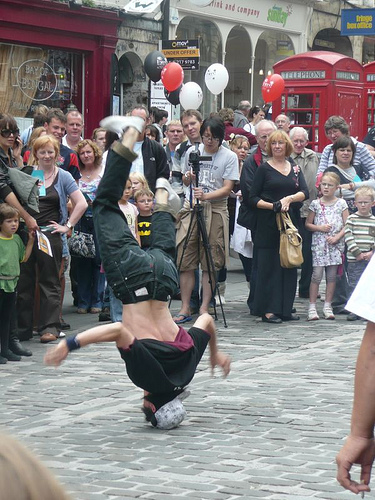

--------------------
Original Model Output:
A street performer is standing on his head on a brick street in front of a crowd while he is being filmed in front of a red telephone box.
--------------------
Quantized Model Output:
A street performer is standing on his head on a brick street in front of a crowd while he is being filmed in front of a red telephone box.

--- Sample 2 ---
Image: 3217789209.jpg


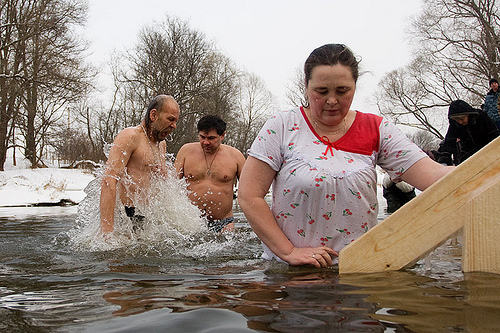

--------------------
Original Model Output:
A woman in a floral dress is standing waist deep in icy water, with two shirtless men beside her, as they all appear to be enjoying a cold dip in a natural setting with snow on the ground and leafless trees in the background.
--------------------
Quantized Model Output:
A woman in a floral dress is standing waist deep in icy water, with two shirtless men beside her, as they all appear to be enjoying themselves in a cold, snowy environment with leafless trees in the background.

--- Sample 3 ---
Image: 4632399460.jpg


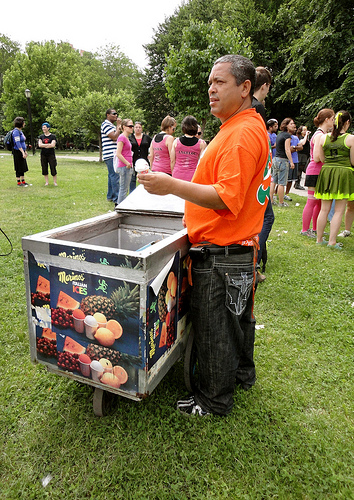

--------------------
Original Model Output:
A man in a bright orange shirt and black jeans holds an ice cream cone out of a small vending cooler while other people stand around.
--------------------
Quantized Model Output:
A man in a bright orange shirt and black jeans holds an ice cream cone out of a small vending cooler while other people stand around.

--- Comparison Script Finished ---


In [6]:
import torch
import transformers
from transformers import AutoModelForCausalLM, AutoProcessor
from PIL import Image
import os
import sys
from tqdm import tqdm
import pandas as pd
import random
import traceback
import psutil
import gc
import numpy as np

from IPython.display import display, Image as IPImage
from torch.utils.data import Dataset, DataLoader

module_dir_working = '/kaggle/working'
module_dir_input_scripts = '/kaggle/input/gptqoriginal'

if module_dir_working not in sys.path:
    sys.path.insert(0, module_dir_working)
if module_dir_input_scripts not in sys.path:
    sys.path.insert(0, module_dir_input_scripts)

try:
    from modelutils import find_layers
    from quant import quantize, Quantizer
    print("Custom modules imported successfully.")
except ImportError as e:
    print(f"Error importing custom modules: {e}")
    print(f"Please ensure modelutils.py, quant.py are in the Python path (e.g., {module_dir_input_scripts} or {module_dir_working})")
    sys.exit(1)

import warnings
warnings.filterwarnings('ignore')

MODEL_ID = 'microsoft/Phi-3.5-vision-instruct'
QUANTIZERS_PATH = '/kaggle/working/phi3_vision_8bit_quantizers_wf_inspired.pt'
SAMPLE_IMAGE_DIR = '/kaggle/working/flickr30k_calibration'
SAMPLE_CAPTIONS_PATH = '/kaggle/input/flickr30k/captions.txt'
NUM_INFERENCE_SAMPLES = 3
WBITS = 8


class FlickrDataset(Dataset):
    def __init__(self, image_dir, captions_path, num_samples=None):
        self.image_dir = image_dir
        if not os.path.exists(captions_path): raise FileNotFoundError(f"Captions file not found: {captions_path}")
        if not os.path.isdir(image_dir): raise FileNotFoundError(f"Image directory not found: {image_dir}")
        try:
             try: df_captions = pd.read_csv(captions_path, delimiter=',', header=None)
             except (ValueError, pd.errors.ParserError): df_captions = pd.read_csv(captions_path, delimiter='\t', header=None)
             if df_captions.shape[1] >= 3: df_captions.columns = ['image_name', 'caption_index', 'caption'] + [f'extra_{i}' for i in range(df_captions.shape[1] - 3)]
             elif df_captions.shape[1] == 2: df_captions.columns = ['image_name', 'caption']; df_captions['caption_index'] = 0
             else: raise ValueError(f"Captions file has unexpected number of columns ({df_captions.shape[1]})")
        except Exception as e: raise ValueError(f"Failed to parse captions file {captions_path}: {e}")

        df_captions['caption'] = df_captions['caption'].astype(str).str.strip()
        self.samples = []
        all_image_files = {f for f in os.listdir(image_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))}
        valid_image_names = list(all_image_files.intersection(set(df_captions['image_name'].unique())))
        for img_name in valid_image_names:
             first_caption = df_captions[df_captions['image_name'] == img_name]['caption'].iloc[0]
             self.samples.append((img_name, first_caption))
        if not self.samples: raise ValueError("No valid image/caption pairs found between directory and captions file.")
        if num_samples is not None and 0 < num_samples < len(self.samples):
             self.samples = random.sample(self.samples, num_samples)

    def __len__(self): return len(self.samples)
    def __getitem__(self, idx):
        img_name, caption_text = self.samples[idx]
        img_path = os.path.join(self.image_dir, img_name)
        return img_path, caption_text

def apply_quantizers(model, quantizers_dict_cpu):
    if not quantizers_dict_cpu: print("No quantizers provided."); return 0
    print("Applying loaded quantizers to the model...")
    layers = find_layers(model)
    applied_count = 0; skipped_layers = []
    with torch.no_grad():
         for name, module in tqdm(layers.items(), desc="Applying Quantizers"):
             if name in quantizers_dict_cpu:
                 if not hasattr(module, 'weight') or module.weight is None: skipped_layers.append(name+" (no weight)"); continue
                 try:
                     q_state = quantizers_dict_cpu[name]; layer_dev = module.weight.device
                     scale = q_state.scale.to(layer_dev); zero = q_state.zero.to(layer_dev); maxq = q_state.maxq
                     quantized_weight = quantize(module.weight.data, scale, zero, maxq)
                     module.weight.data = quantized_weight.to(module.weight.dtype); applied_count += 1
                     del scale, zero, q_state
                 except AttributeError as e_attr: print(f"Attr Err apply Q {name}: {e_attr}."); skipped_layers.append(name + " (attr error)")
                 except Exception as e: print(f"Err apply Q {name}: {e}"); skipped_layers.append(name+" (error)")
    print(f"Finished applying {applied_count} quantizers.")
    if skipped_layers: print(f"Warn: Skipped apply {len(skipped_layers)} layers: {skipped_layers[:10]}...")
    return applied_count

def print_memory_usage(stage_name):
    process = psutil.Process(os.getpid())
    ram_mb = process.memory_info().rss / (1024 * 1024)
    print(f"--- Memory Usage ({stage_name}) ---")
    print(f"  Process RAM : {ram_mb:.2f} MB")
    if torch.cuda.is_available() and torch.cuda.device_count() > 0:
        gpu_id = 0
        print(f"  GPU {gpu_id} VRAM Allocated : {torch.cuda.memory_allocated(gpu_id) / (1024 * 1024):.2f} MB")
        print(f"  GPU {gpu_id} VRAM Reserved  : {torch.cuda.memory_reserved(gpu_id) / (1024 * 1024):.2f} MB")
    elif torch.cuda.is_available(): print("  No CUDA devices detected.")
    else: print("  CUDA not available.")
    print("-" * (24 + len(stage_name)))

def inspect_quantizer_params(quantizers_dict, layer_name):
    print(f"\n--- Inspecting Quantizer Params for: {layer_name} ---")
    if layer_name in quantizers_dict:
        q_state = quantizers_dict[layer_name]
        try:
            scale = q_state.scale; zero = q_state.zero; maxq = q_state.maxq; bits = q_state.bits
            print(f"  Bits (wbits): {bits}"); print(f"  Max Quant Value (maxq): {maxq}")
            print(f"  Scale Tensor Shape: {scale.shape}"); print(f"  Zero Point Tensor Shape: {zero.shape}")
            print(f"  Sample Scale Values: {scale.flatten()[:5].tolist()} ..."); print(f"  Sample Zero Point Values: {zero.flatten()[:5].tolist()} ...")
            if (maxq == (2**WBITS - 1)): print(f"  Check PASSED: maxq ({maxq}) matches expected for {WBITS}-bit.")
            else: print(f"  Check WARNING: maxq ({maxq}) != expected ({2**WBITS - 1}) for {WBITS}-bit.")
        except AttributeError as e: print(f"  Error accessing attributes for {layer_name}: {e}")
        except Exception as e: print(f"  An error occurred during inspection: {e}")
    else: print(f"  Quantizer params for {layer_name} not found.")
    print("-" * (50 + len(layer_name)))

def verify_requantization(model, quantizers_dict_cpu, layer_name):
     print(f"\n--- Verifying Re-Quantization for Layer: {layer_name} ---")
     try:
          module = model.get_submodule(layer_name)
          if not hasattr(module, 'weight') or module.weight is None:
               print("  Layer has no weight. Cannot verify."); return

          if layer_name not in quantizers_dict_cpu:
               print(f"  Quantizer parameters for {layer_name} not found. Cannot verify."); return

          weight_data = module.weight.data 
          layer_dev = weight_data.device
          q_state = quantizers_dict_cpu[layer_name]

          scale = q_state.scale.to(layer_dev)
          zero = q_state.zero.to(layer_dev)
          maxq = q_state.maxq

          if scale.ndim == 1: scale = scale.unsqueeze(-1)
          if zero.ndim == 1: zero = zero.unsqueeze(-1)
          epsilon = 1e-6
          W_quant_recalc = torch.round(weight_data / (scale + epsilon) + zero)

          min_val = torch.min(W_quant_recalc)
          max_val = torch.max(W_quant_recalc)

          print(f"  Weight dtype after apply_quantizers: {weight_data.dtype}")
          print(f"  Re-calculated integer values range: [{min_val.item():.2f}, {max_val.item():.2f}]")
          print(f"  Expected integer range for {WBITS}-bit: [0, {maxq}]")

          # Check if the re-calculated values are within the expected integer range
          min_check_passed = min_val >= -0.5 # Allow for rounding error
          max_check_passed = max_val <= maxq + 0.5 # Allow for rounding error

          if min_check_passed and max_check_passed:
               print("  Verification PASSED: Re-quantized values fall within the expected {WBITS}-bit integer range.")
          else:
               print("  Verification FAILED: Re-quantized values fall OUTSIDE the expected {WBITS}-bit integer range.")
               if not min_check_passed: print(f"    Min value {min_val.item():.2f} is below 0.")
               if not max_check_passed: print(f"    Max value {max_val.item():.2f} is above {maxq}.")
          del scale, zero, W_quant_recalc, q_state # Clean up

     except AttributeError as e: print(f"  Attribute Error during re-quant check: {e}. Check layer name and quantizer structure.")
     except Exception as e: print(f"  An error occurred during re-quant check: {e}"); traceback.print_exc()
     print("-" * (50 + len(layer_name)))


def run_inference_on_samples(model, processor, samples, generation_args, description):
    results = {}
    print(f"\n--- Running Inference ({description}) ---")
    for i, (img_path, caption) in enumerate(tqdm(samples, desc=f"Inference ({description})")):
        try:
             image = Image.open(img_path).convert("RGB")
             placeholder = "<|image_1|>\n"; user_content = placeholder + str(caption).strip()
             messages = [{"role": "user", "content": user_content}]
             prompt = processor.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
             inputs = processor(prompt, [image], return_tensors="pt")
             with torch.no_grad():
                 generate_ids = model.generate(**inputs, eos_token_id=processor.tokenizer.eos_token_id, **generation_args)
             input_token_len = inputs['input_ids'].shape[1]
             generate_ids = generate_ids[:, input_token_len:]
             response = processor.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
             results[i] = response
        except Exception as e: print(f"\nError during {description} inference S{i+1}: {e}"); traceback.print_exc(); results[i] = f"ERROR: {e}"
        finally: del inputs, generate_ids; torch.cuda.empty_cache()
    print(f"--- Finished Inference ({description}) ---")
    return results


if __name__ == '__main__':
    DEV = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    DTYPE = torch.float16 if torch.cuda.is_available() else torch.float32
    print(f"Using dtype: {DTYPE}")

    print_memory_usage("Start")

    print(f"Loading base model: {MODEL_ID}")
    try:
        model = AutoModelForCausalLM.from_pretrained(MODEL_ID, torch_dtype=DTYPE, trust_remote_code=True, _attn_implementation='eager', device_map="auto")
        processor = AutoProcessor.from_pretrained(MODEL_ID, trust_remote_code=True)
        model.eval(); print("Base model loaded successfully.")
    except Exception as e: print(f"Error loading base model: {e}"); traceback.print_exc(); sys.exit(1)

    print_memory_usage("After Base Model Load")

    print("\nPreparing fixed sample data for inference...")
    try:
        dataset = FlickrDataset(SAMPLE_IMAGE_DIR, SAMPLE_CAPTIONS_PATH, num_samples=NUM_INFERENCE_SAMPLES)
        inference_samples = [(os.path.join(dataset.image_dir, s[0]), s[1]) for s in dataset.samples]
        del dataset
        if not inference_samples: raise ValueError("No inference samples prepared.")
        print(f"Selected {len(inference_samples)} samples for inference comparison.")
    except Exception as e: print(f"Error preparing inference data: {e}"); sys.exit(1)

    generation_args = { "max_new_tokens": 100, "temperature": 0.0, "do_sample": False }
    original_responses = run_inference_on_samples(model, processor, inference_samples, generation_args, "Original Model")

    print_memory_usage("After Original Inference")

    print(f"\nLoading quantizers from: {QUANTIZERS_PATH}")
    if not os.path.exists(QUANTIZERS_PATH): print("Error: Quantizer file not found."); sys.exit(1)
    try: quantizers_cpu = torch.load(QUANTIZERS_PATH, map_location='cpu'); print(f"Successfully loaded {len(quantizers_cpu)} quantizer parameter sets.")
    except Exception as e: print(f"Error loading quantizers file: {e}"); sys.exit(1)

    sample_layer_to_inspect = list(quantizers_cpu.keys())[0]
    inspect_quantizer_params(quantizers_cpu, sample_layer_to_inspect)

    applied_count = apply_quantizers(model, quantizers_cpu)

    if torch.cuda.is_available():
        print("\nClearing CUDA cache after applying quantizers..."); gc.collect(); torch.cuda.empty_cache(); print("CUDA cache cleared.")

    print_memory_usage("After Applying Quantizers")

    sample_layer_to_check = 'model.layers.10.mlp.gate_up_proj'
    if applied_count > 0 and sample_layer_to_check in quantizers_cpu:
         verify_requantization(model, quantizers_cpu, sample_layer_to_check)
    elif applied_count == 0:
         print(f"\nSkipping re-quantization check as no quantizers were applied.")
    else:
         print(f"\nSkipping re-quantization check as layer {sample_layer_to_check} might not be in quantizers dict.")

    del quantizers_cpu # Free CPU memory holding the dict

    quantized_responses = run_inference_on_samples(model, processor, inference_samples, generation_args, "Quantized Model")

    print_memory_usage("After Quantized Inference")

    print("\n--- Comparison of Inference Results ---")
    for i, (img_path, caption) in enumerate(inference_samples):
        print(f"\n--- Sample {i+1} ---")
        print(f"Image: {os.path.basename(img_path)}")
        try: display(IPImage(filename=img_path, width=300))
        except Exception as display_e: print(f"[Could not display image {img_path}: {display_e}]")
        print("-" * 20)
        print(f"Original Model Output:\n{original_responses.get(i, 'ERROR')}")
        print("-" * 20)
        print(f"Quantized Model Output:\n{quantized_responses.get(i, 'ERROR')}")
        print("=" * 40)

    print("\n--- Comparison Script Finished ---")